# MINIST
获取MNIST数据

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home="./datasets")
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

#### 获取不到MNIST数据，另外使用 "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat" 获取的数据。

In [2]:
def fetch_mldata_alternative():
    from six.moves import urllib
    from sklearn.datasets import fetch_mldata
    try:
        # mnist = fetch_mldata('MNIST original')
        mnist = fetch_mldata('MNIST original', data_home='./datasets')
    except:
        print("Could not download MNIST data from mldata.org, trying alternative...")

        # Alternative method to load MNIST, if mldata.org is down
        from scipy.io import loadmat
        mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
        mnist_path = "./mnist-original.mat"
        response = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_path, "wb") as f:
            content = response.read()
            f.write(content)
        mnist_raw = loadmat(mnist_path)
        mnist = {
            "data": mnist_raw["data"].T,
            "target": mnist_raw["label"][0],
            "COL_NAMES": ["label", "data"],
            "DESCR": "mldata.org dataset: mnist-original",
        }
        print("Success!")
    return mnist

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

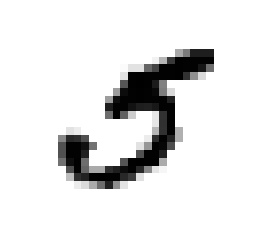

In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [6]:
y[36000]

5.0

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[:6000]

In [8]:
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 训练一个二分类器

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5, random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

# 对性能的评估

## 使用交叉验证测量准确性

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):    
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
   

0.9668
0.95965
0.96265


In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9668 , 0.95965, 0.96265])

#### 总是返回False的模型也有90+%的准确率

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90805, 0.9109 , 0.91   ])

## 混淆矩阵

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53832,   747],
       [ 1471,  3950]], dtype=int64)

#### 一个完美的分类器将只有真反例和真正例，所以混淆矩阵的非零值仅在其主对角线（左上至右下）

In [17]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 准确率与召回率

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8409623163721525

In [19]:
4177 / (4177 + 844)

0.8319059948217487

In [20]:
recall_score(y_train_5, y_train_pred)

0.7286478509500092

In [22]:
4177 / (4177 + 1244)

0.7705220439033389

In [25]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7807867167424392

In [28]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([68891.6905938])

In [33]:
threshhold = 0
y_some_digit_pred = (y_scores > threshhold)
y_some_digit_pred

array([ True])

In [35]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [39]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([-1412651.573921  ,  -201092.36218366,  -945980.19744651, ...,
         -96123.41315785,  -132297.37422232,  -559374.07609645])

In [41]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

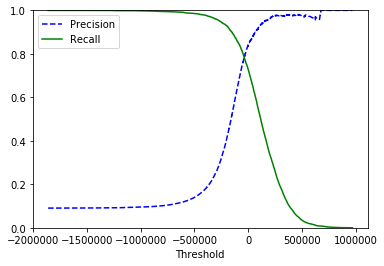

In [44]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()